<a href="https://colab.research.google.com/github/komorimasashi/time_series_book/blob/main/chapter5/Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列データ同士の関係の評価

In [11]:
#必要なパッケージのインストール
targetPackages <- c('fields','zoo','MARSS','seewave','WaveletComp','gtrendsR','circular','TSclust','crqa','nonlinearTseries','tsDyn','vars') 
newPackages <- targetPackages[!(targetPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages)

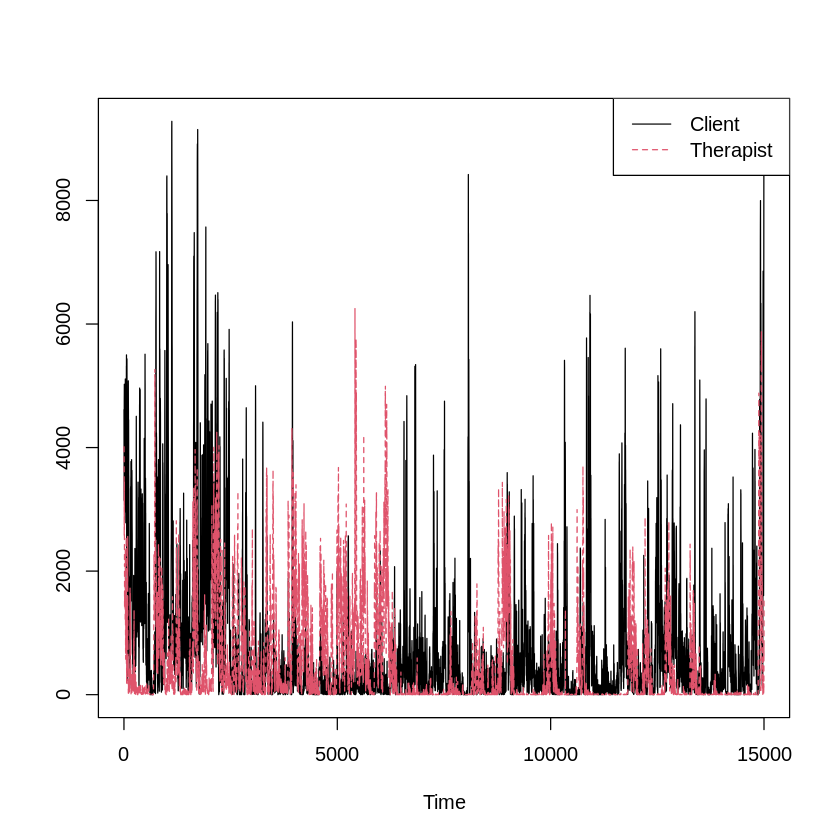

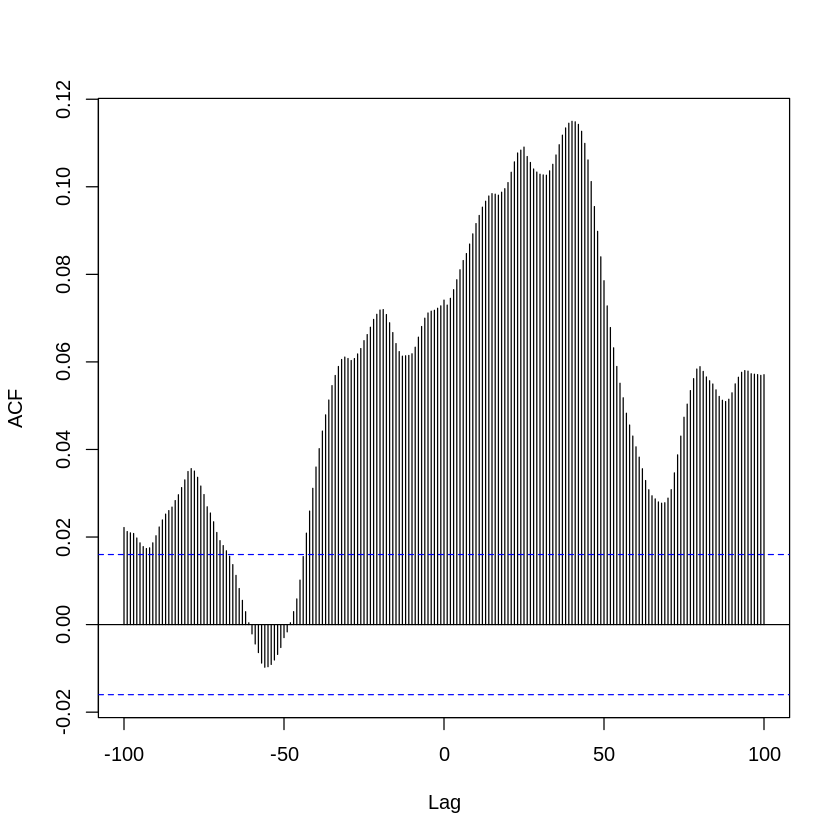

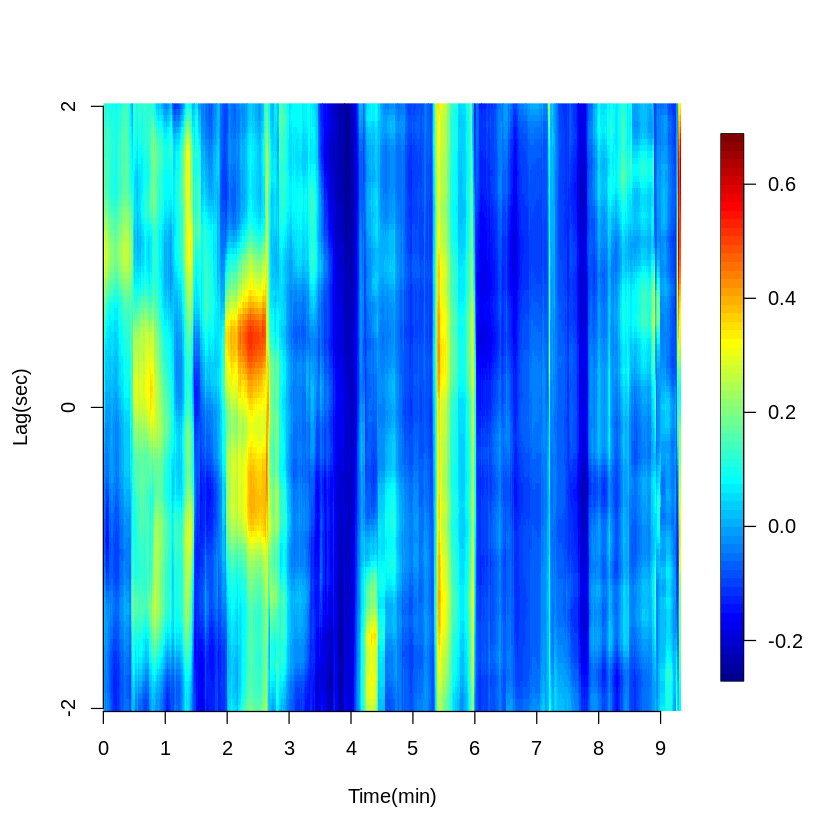

In [12]:
# 5.2 相互相関

library(fields) # image.plot()を使うため
library(zoo) # rollapplyr()を使うため

# 相互相関
# {rMEA}パッケージに含まれるデータが公開されているgithubのリポジトリ内のファイル
url<-"https://raw.githubusercontent.com/kleinbub/rMEA/master/inst/extdata/normal/203_01.txt"
dat <- read.table(url, sep = " ", header=TRUE)

# 体の動きの大きさの時系列プロット
ts.plot(dat, lty=c(1:2), col=c(1:2))
legend("topright",c("Client","Therapist"),lty=c(1:2),col=c(1:2))

# 相互相関関数
r <- ccf(dat[,1], dat[,2], type = "correlation", lag.max = 100, plot=T, main="")


# 移動ラグ相関
# 相関係数を求める自作関数
corr <- function(x) ccf(x[, 1], x[,2], type = "correlation",lag.max = laglen, plot=F)$acf

# パラメータの設定
window <- 1000 # 相関係数の窓長を1000にする
laglen <- 50 # 考慮するラグの長さ
fps <- 25 # frame per second（1秒間の映像コマ数）
df <- data.frame(dat)
cor_mat<- rollapplyr(df, window, corr, by.column=F)

# 作図
colnames(cor_mat) <- c(-laglen:laglen)
rownames(cor_mat) <- 1:nrow(cor_mat)
image.plot(cor_mat,axes =F, xlab="Time(min)", ylab="Lag(sec)")
axis(1, at=seq(0,1, by=1500/(nrow(cor_mat)-1)),labels=seq(0,14000,　by=1500)/(60*fps))
axis(2, at=seq(0,1, by=50/(ncol(cor_mat)-1)),labels=seq(-laglen, laglen, by=50)/25)



[1] "DTW (global): 26.25"

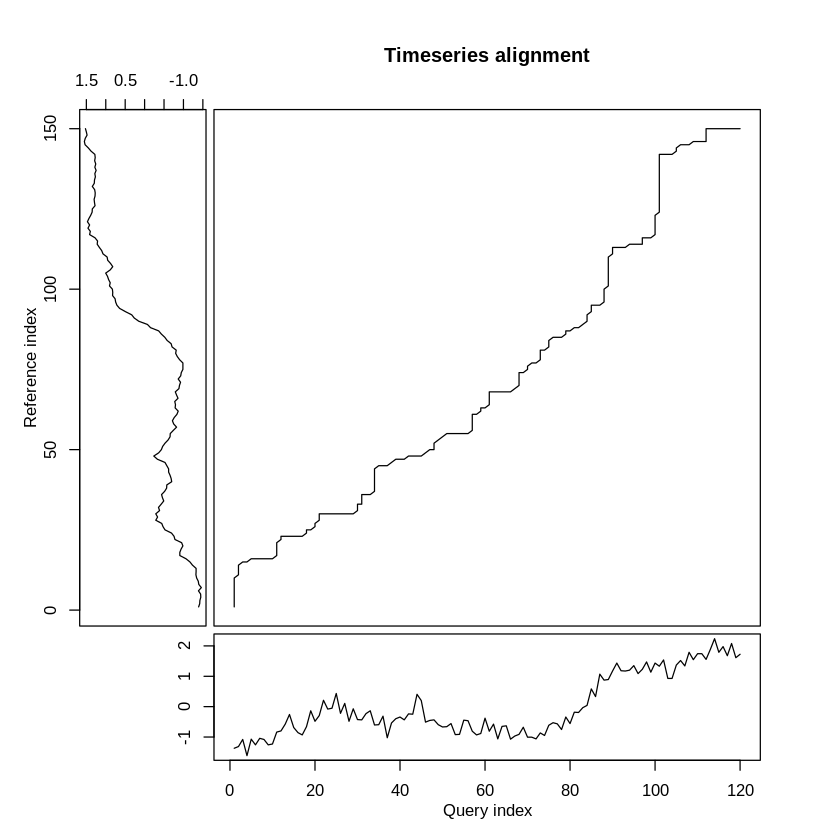

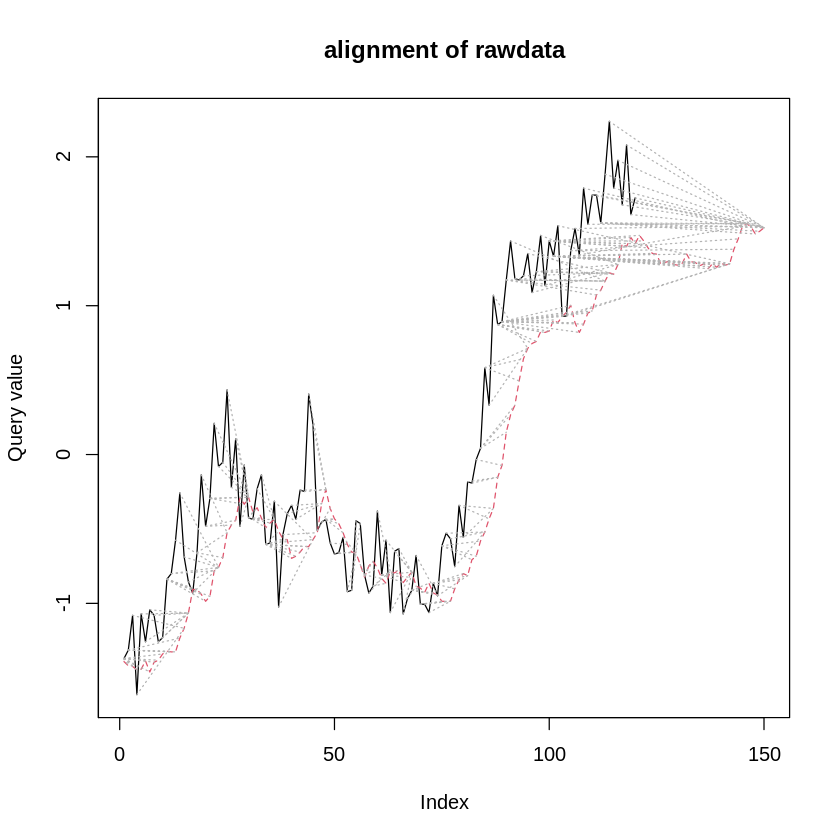

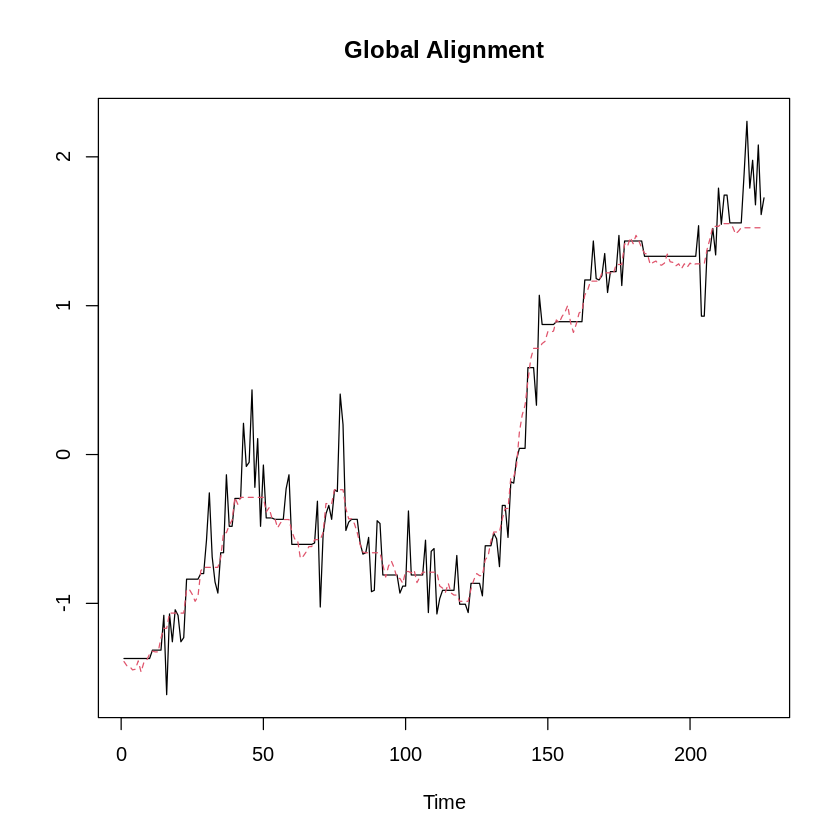

[1] "DTW (windowed, global) distance: 30.43"

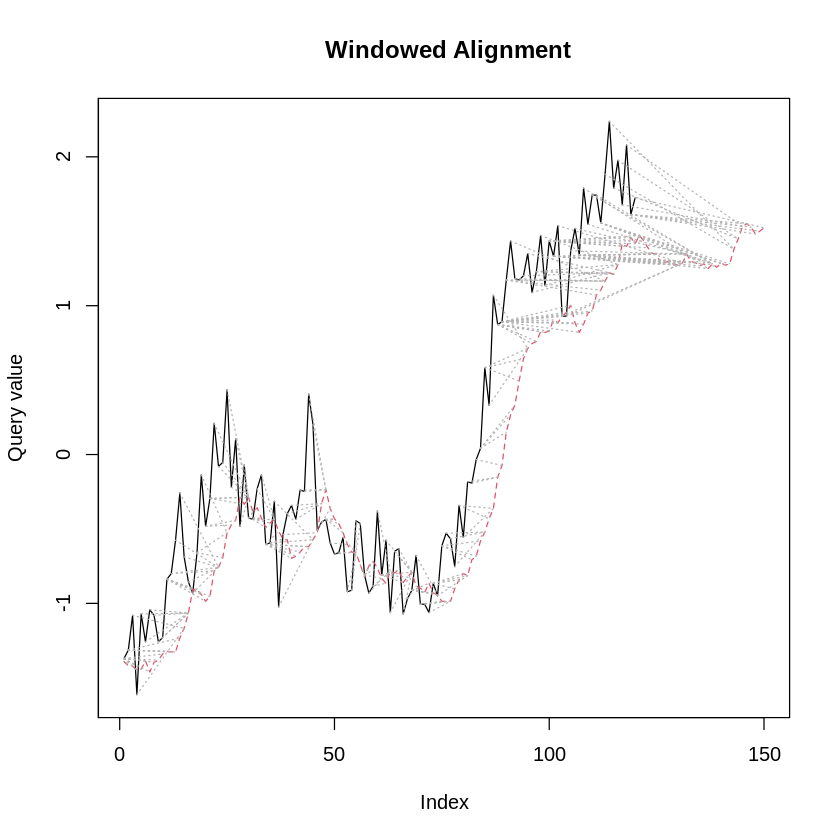

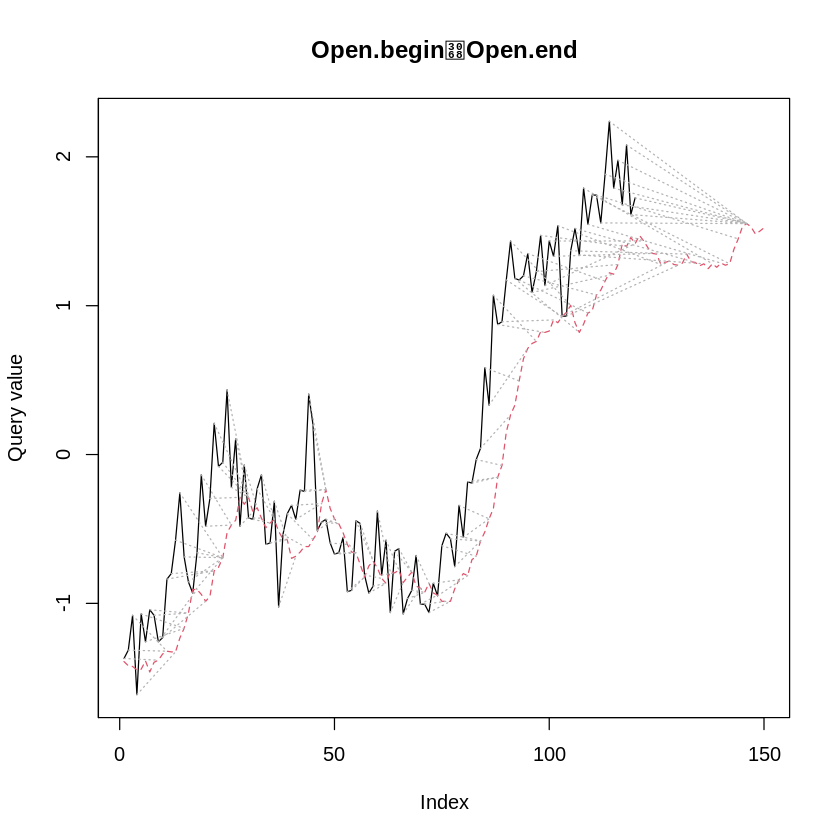

[1] "DTW(local): 20.08"

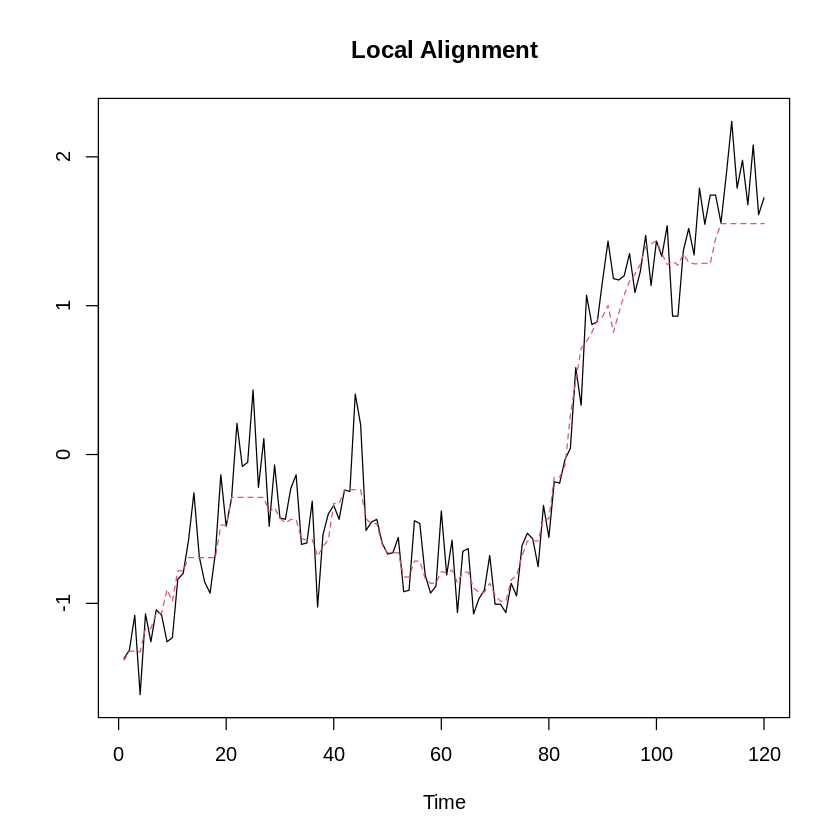

In [13]:
# 5.3.1 1 次元データの動的時間伸縮

library(dtw)

data("BJsales")

# 異なる期間のデータを抜き出すのでデータの長さは異なる
# 120サンプル抜き出して標準化, Query
ts1 <- scale(BJsales.lead[1:120])
# 150サンプル抜き出して標準化, Reference
ts2 <- scale(BJsales[1:150])

# DTW
# アライメントを調べる
alignment <- dtw(ts1, ts2)
# 時系列点の対応関係
dtwPlotThreeWay(alignment, xts=ts1, yts=ts2)
# DTWで計算した距離
sprintf("DTW (global): %5.2f", alignment$distance)
# 描画
dtwPlotTwoWay(alignment, xts=ts1, yts=ts2, main="alignment of rawdata")
ts.plot(as.ts(ts1[alignment$index1]), as.ts(ts2[alignment$index2]), col=c(1:2), lty=c(1:2), main="Global Alignment")

# DTWのオプション
# 探索範囲の窓長に制限を加える
alignment.window = dtw(ts1, ts2, window.type = "sakoechiba", window.size = abs(length(ts1) - length(ts2)))
dtwPlotTwoWay(alignment.window, xts=ts1, yts=ts2, main=" Windowed Alignment")
sprintf("DTW (windowed, global) distance: %5.2f", alignment.window$distance) # 距離

# open.end と open.beginで類似度の高い区間だけ抜き出す
alignment.openend = dtw(ts1, ts2, step=asymmetric, open.end=TRUE,open.begin=TRUE)
dtwPlotTwoWay(alignment.openend, xts=ts1, yts=ts2, main="Open.beginとOpen.end")

ts.plot(as.ts(ts1[alignment.openend$index1]),
        as.ts(ts2[alignment.openend$index2]),
        col=c(1:2),lty=c(1:2), main="Local Alignment")

sprintf("DTW(local): %5.2f", alignment.openend$distance) # 距離


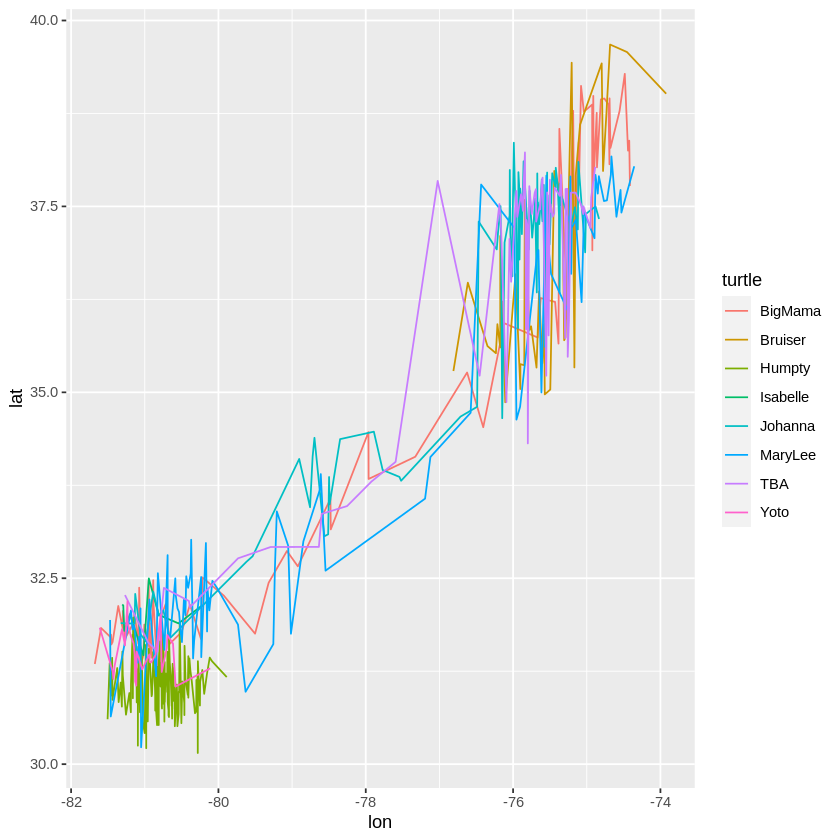

[1] 80.55697

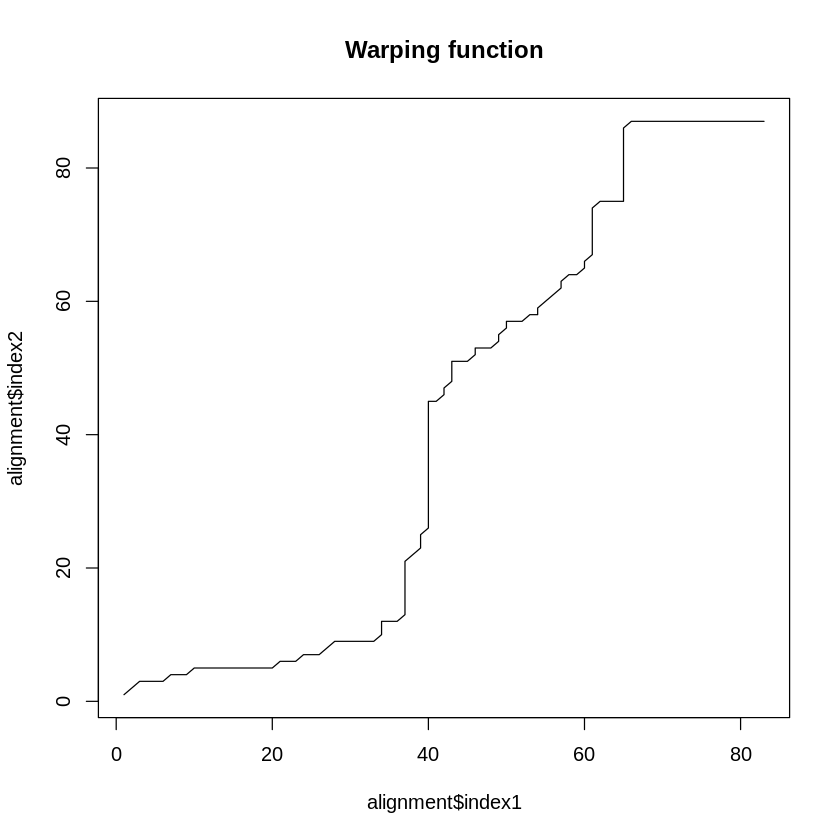

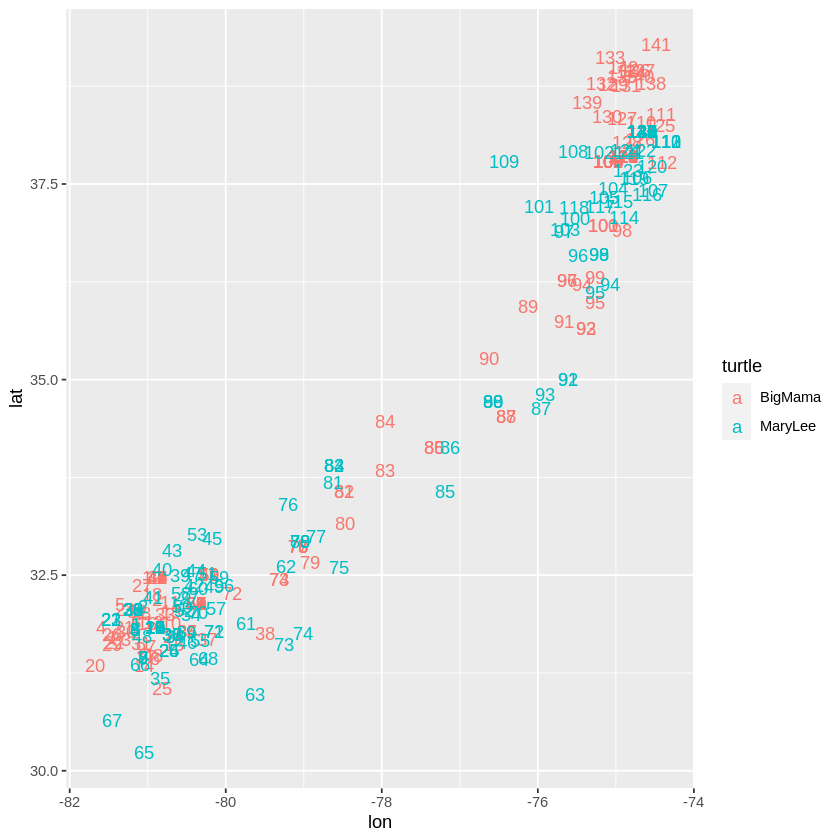

In [14]:
# 5.3.2 2 次元データの動的時間伸縮

library(ggplot2)
library(MARSS)

# アカウミガメ位置情報データ
# 位置情報の単位は緯度（latitude: lat)と経度(longitude: lon)です
data(loggerhead)
dat <- loggerheadNoisy
g <- ggplot(dat, aes(x = lon, y = lat, color = turtle))+ geom_line()
plot(g)

# 2次元データのDynamic Time Warping
library(dtw)
# BigMama，MaryLeeと名付けられた2匹のウミガメのデータを取り出します
ts1 <- subset(dat, turtle=='BigMama')[,c("lon","lat")]
ts2 <- subset(dat, turtle=='MaryLee')[,c("lon","lat")]

# 時系列点の対応関係を調べる
# 距離を求める関数proxy::dist()を使います
alignment <-dtw(proxy::dist(ts1,ts2))
plot(alignment$index1, alignment$index2, main="Warping function",type='l')

# DTWで計算した距離
alignment$distance

# 描画
b <- data.frame(
  lon = ts1$lon[alignment$index1], lat = ts1$lat[alignment$index1],
  row_num = 1:length(alignment$index1)
)

m <- data.frame(
  lon = ts2$lon[alignment$index2], lat = ts2$lat[alignment$index2],
  row_num = 1:length(alignment$index2)
)

x <- rbind(data.frame(turtle = "BigMama", b), data.frame(turtle = "MaryLee", m))
g <- ggplot(x, aes(x = lon, y = lat, color = turtle))
g <- g + geom_text(aes(label=row_num))
plot(g)

[1] 1.570796

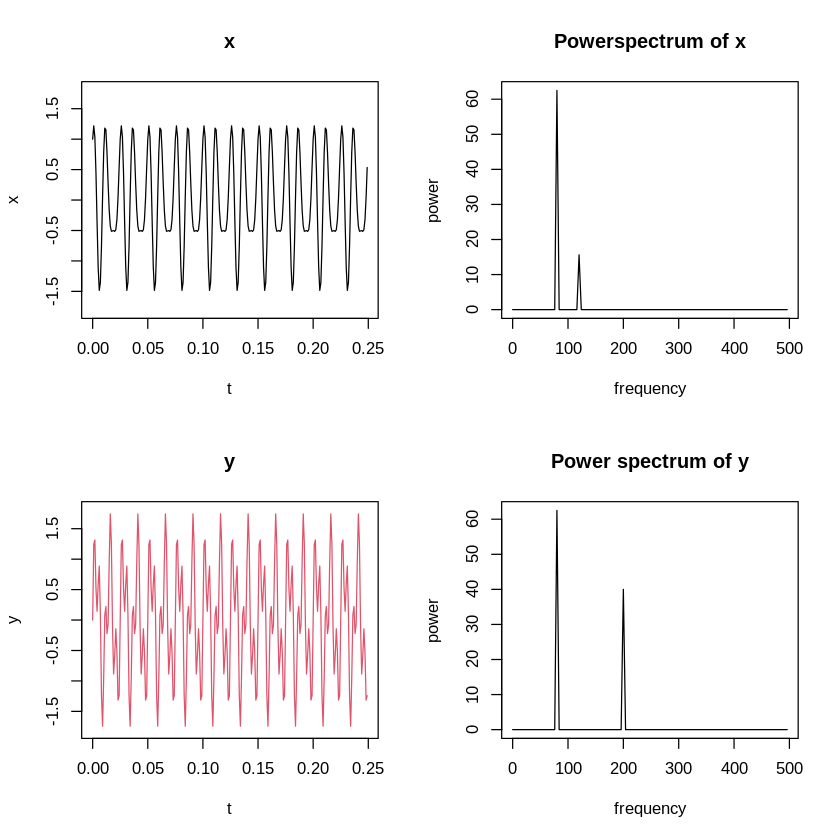

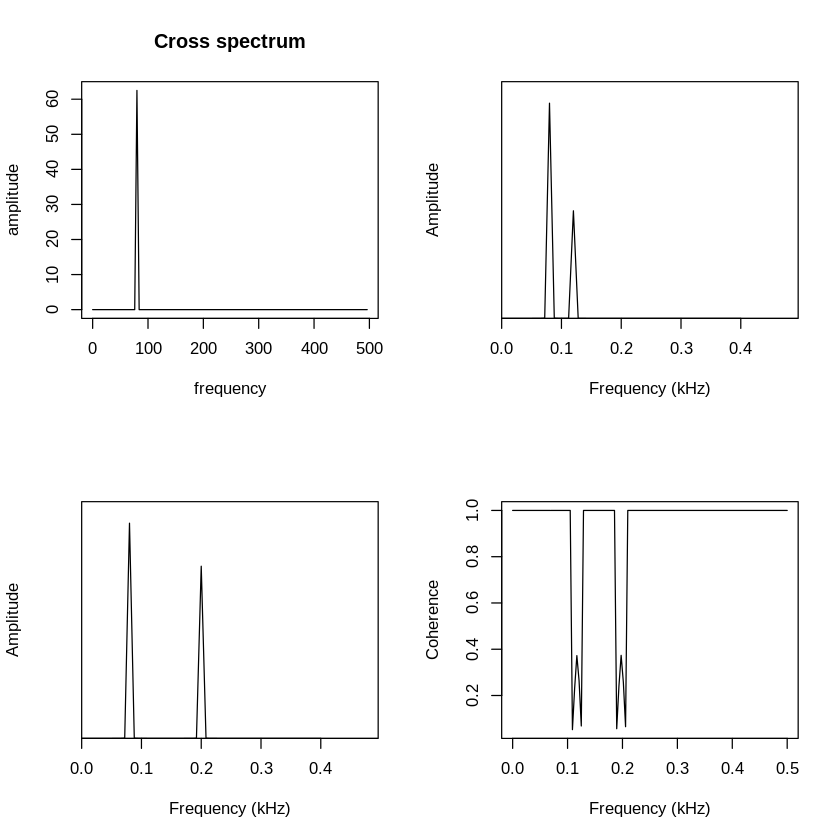

In [15]:
# 5.4.1 コヒーレンス

# 信号の作成
# 1000Hzのサンプリングレートで0.25秒のデータデータを作成
t <- seq(0,.2499, by=0.001)
# xには80Hzのcos波形と120Hzのsin波形
x <- cos(2*pi*80*t) + 0.5*sin(2*pi*120*t)
# yには80Hzのsin波形と200Hzのcos波形
y <- sin(2*pi*80*t) + 0.8*sin(2*pi*200*t)

# パワースペクトル
X <- fft(x,250) # xをフーリエ変換
Y <- fft(y,250) # yをフーリエ変換
frequency <- 1000/250*(0:124) # ナイキスト周波数の範囲を設定
Pxx <- Conj(X)*X/250 # xのパワースペクトルを求める．Conj()は複素共役
Pyy <- Conj(Y)*Y/250 # yのパワースペクトルを求める

par(mfrow=c(2,2))
plot(t,x,type="l",col=1, ylim=c(-1.8,1.8), main="x")
plot(frequency, Re(Pxx)[1:125],type="l", ylab="power", main="Powerspectrum of x")
plot(t,y,type="l",col=2, ylim=c(-1.8,1.8), main="y")
plot(frequency, Re(Pyy)[1:125],type="l",ylab="power",main="Power spectrum of y")

# クロススペクトル
Cxy <- Conj(X)*Y/250
plot(frequency, abs(Cxy)[1:125],type="l", ylab="amplitude", main="Cross spectrum")

# 21番目の要素が80Hzでのθです．π/2位相がずれています
Im(log(Cxy/abs(Cxy)))[21]

# {seewave}による分析
library(seewave)
spec(x, f=1000) # xのパワースペクトル
spec(y, f=1000) # yのパワースペクトル
coh(x, y, f=1000) # xとyのコヒーレンス

Smoothing the time series...
Starting wavelet transformation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave Phase Ampl Power Power.avg Power.pval Power.avg.pval Ridge Period Scale nc nr coi.1 coi.2 axis.1 axis.2 date.format date.tz 


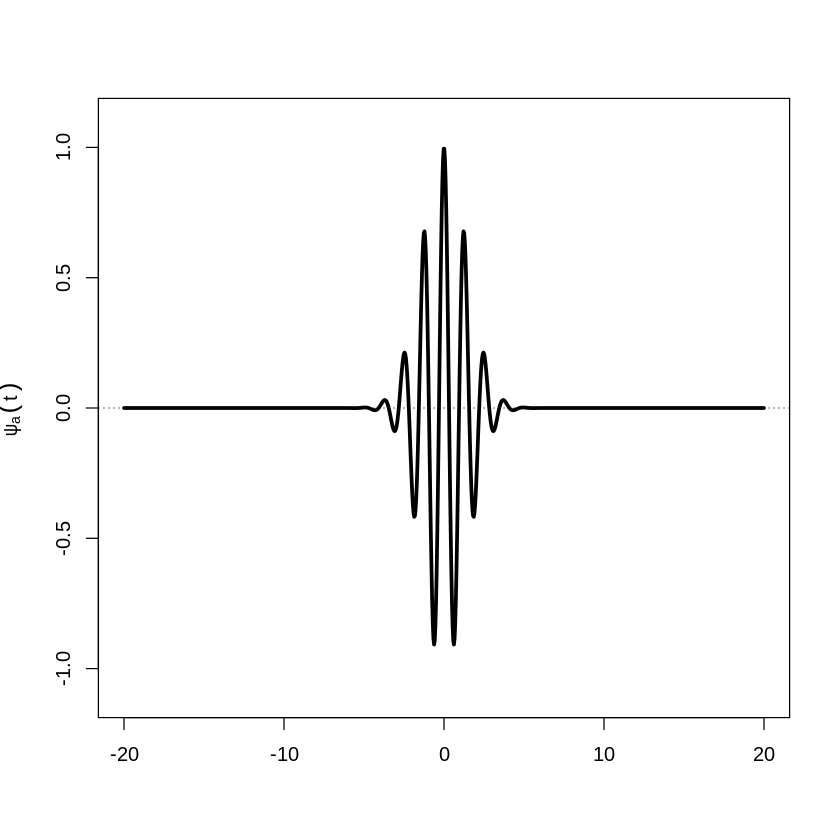

Smoothing the time series...
Starting wavelet transformation and coherency computation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave.xy Angle sWave.xy sAngle Power.xy Power.xy.avg Power.xy.pval Power.xy.avg.pval Coherency Coherence Coherence.avg Coherence.pval Coherence.avg.pval Wave.x Wave.y Phase.x Phase.y Ampl.x Ampl.y Power.x Power.y Power.x.avg Power.y.avg Power.x.pval Power.y.pval Power.x.avg.pval Power.y.avg.pval sPower.x sPower.y Ridge.xy Ridge.co Ridge.x Ridge.y Period Scale nc nr coi.1 coi.2 axis.1 axis.2 date.format date.tz 


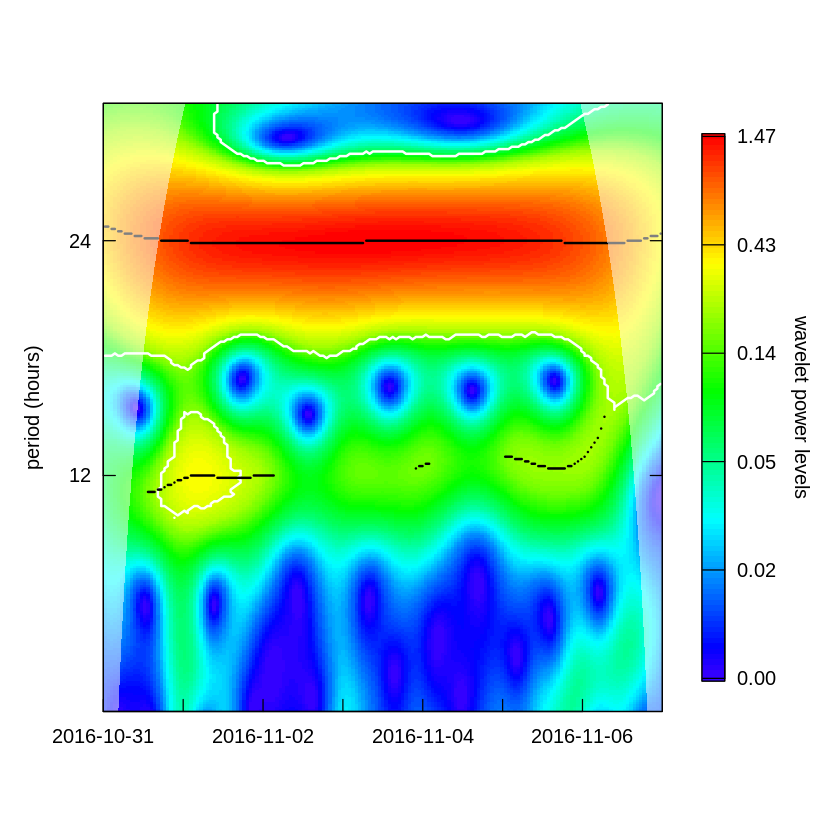

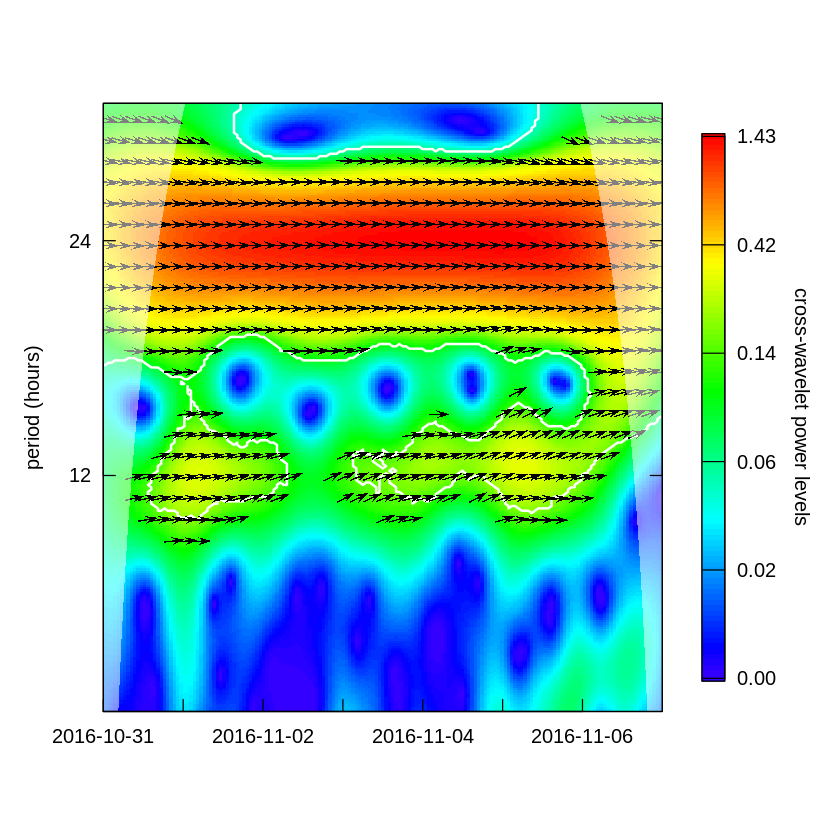

In [16]:
# 5.4.2 ウェーブレットクロススペクトル解析

# Morletウェーブレットの形
morlet <- function(x) exp(-x^2/4) * cos(5*x)
x <- seq(-20,20,length=1000)
y <- morlet(x)
plot(x,y,type="l", lwd=3, ylim=c(-1.1,1.1),xlab="",ylab=expression(psi[a,tau](t)))
abline(h=0, lwd=0.5, lty=3)


# Instagramへの選挙関連投稿数の分析
library(WaveletComp)
data(USelection2016.Instagram)
posts <- apply(USelection2016.Instagram[, 2:5], FUN = "diff", MAR
               = 2)
df <- data.frame(date = as.POSIXct(USelection2016.Instagram$date[-1], tz="EST5EDT"), posts)
at <- seq(from = as.POSIXct("2016-10-31 00:00:00", tz = "EST5EDT"),
          to = as.POSIXct("2016-11-06 00:00:00", tz = "EST5EDT"),
          by = "days")

# ウェーブレット変換
w <- analyze.wavelet(df, "trump.pos", dt = 1, dj = 1/100, lowerPeriod = 6, upperPeriod = 36)
wt.image(w, legend.params = list(lab = "wavelet power levels", label.digits = 2),
         periodlab = "period (hours)", spec.period.axis = list(at = c(12, 24)),
         show.date = TRUE, spec.time.axis = list(at = at)
)

# ウェーブレットクロススペクトル
wc <- analyze.coherency(df, my.pair = c("trump.pos", "clinton.pos"),
                        dt = 1, dj = 1/100, lowerPeriod = 6, upperPeriod = 36)

wc.image(wc, lvl = 0.1, p = 0,
         legend.params = list(lab = "cross-wavelet power levels", label.digits = 2),
         periodlab = "period (hours)", spec.period.axis = list(at = c(12, 24)),
         show.date = TRUE, spec.time.axis = list(at = at))

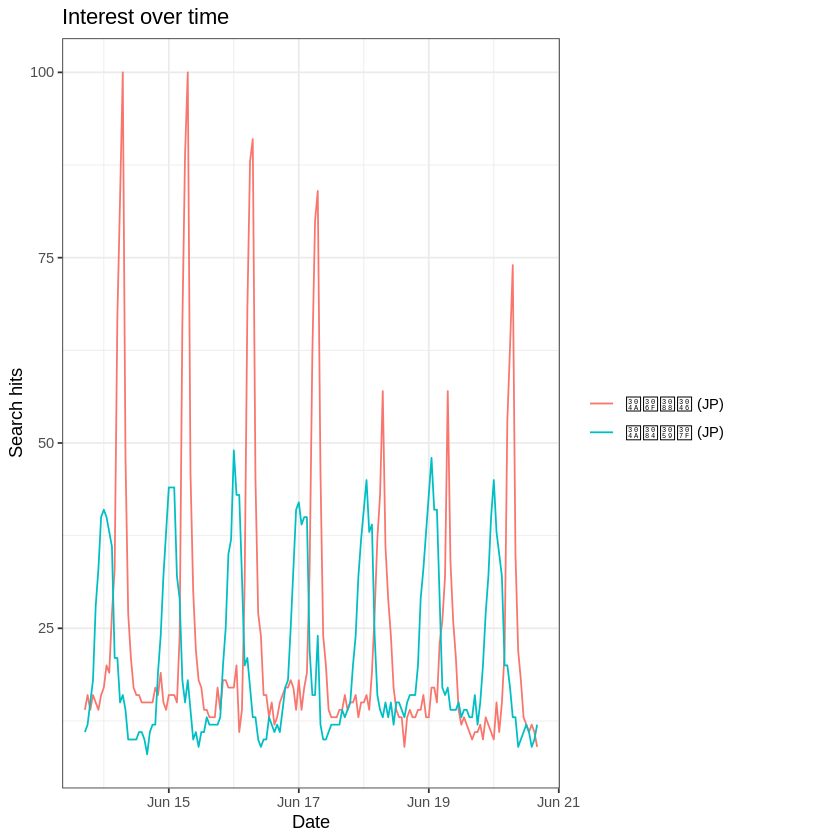

[1] "時間のずれは平均5.859130時間"

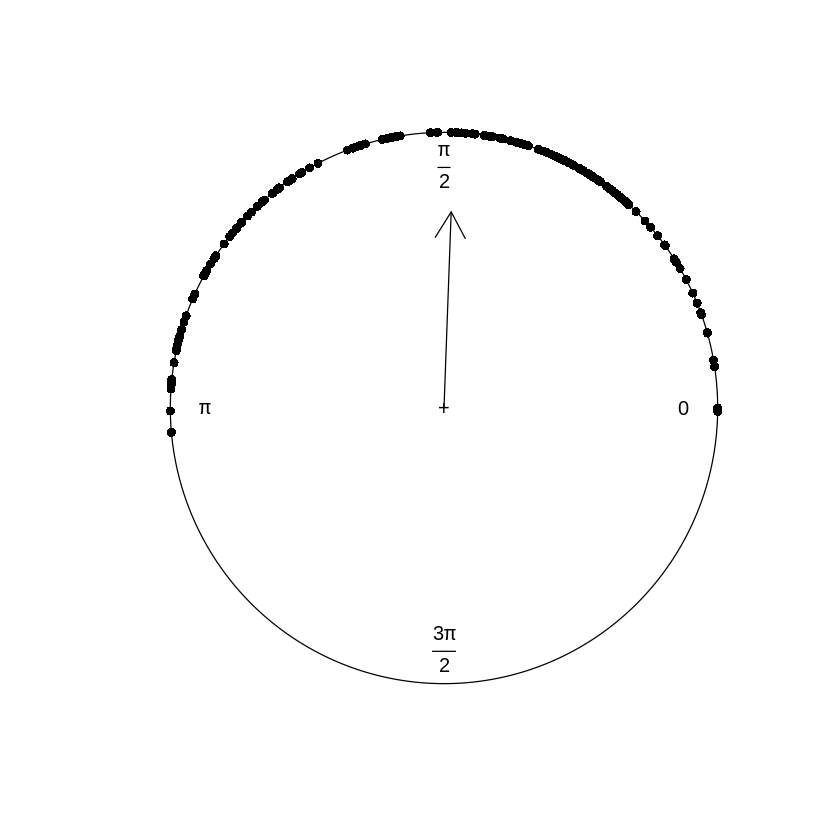

In [17]:
# 5.5 位相差の評価

library(seewave) # 信号処理ライブラリ
library(gtrendsR) # Googleトレンドを取得するライブラリ
library(tidyr)
library(circular) # 角度の計算を行うライブラリ

# Googleトレンドの取得
trend <- gtrends(
  keyword = c("おはよう", "おやすみ"), # 検索キーワード
  geo = "JP", # 検索地域
  # 取得期間．ここでは現在からさかのぼって７日間（24×7)
  time = "now 7-d",
  tz = 'Asia/Tokyo'
)
plot(trend)
df <- as.data.frame(trend$interest_over_time)
df <- df %>% pivot_wider(id_cols = date, names_from = keyword, values_from=hits)
ohayo <- scale(df$'おはよう')
oyasumi <- scale(df$'おやすみ')

# 位相差の算出
# ヒルベルト変換
ohayo.h <- hilbert(ohayo, 1, channel = 1, fftw = FALSE)
# ヒルベルト変換
oyasumi.h <- hilbert(oyasumi, 1, channel = 1, fftw = FALSE)
# 瞬時位相
ohayo.p <- atan2(Im(ohayo.h),Re(ohayo.h))
# 瞬時位相
oyasumi.p <- atan2(Im(oyasumi.h),Re(oyasumi.h))
# 位相差の計算．方向統計学のパッケージを利用
phase_diff <- circular(oyasumi.p - ohayo.p)
# 位相差をプロットしている
plot.circular(phase_diff)
# 平均方向
arrows.circular(x=mean.circular(phase_diff),y=rho.circular(phase_diff))
# 2πを24時間として時間に変換
time_diff <- mean.circular(phase_diff)/(2*pi)*24
sprintf("時間のずれは平均%f時間",time_diff)

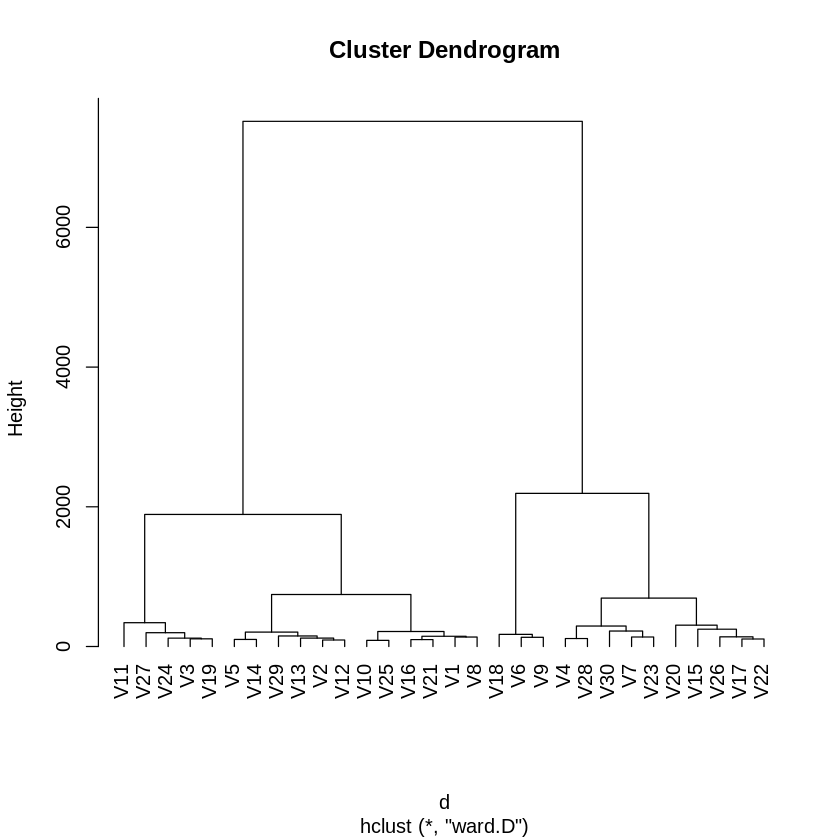

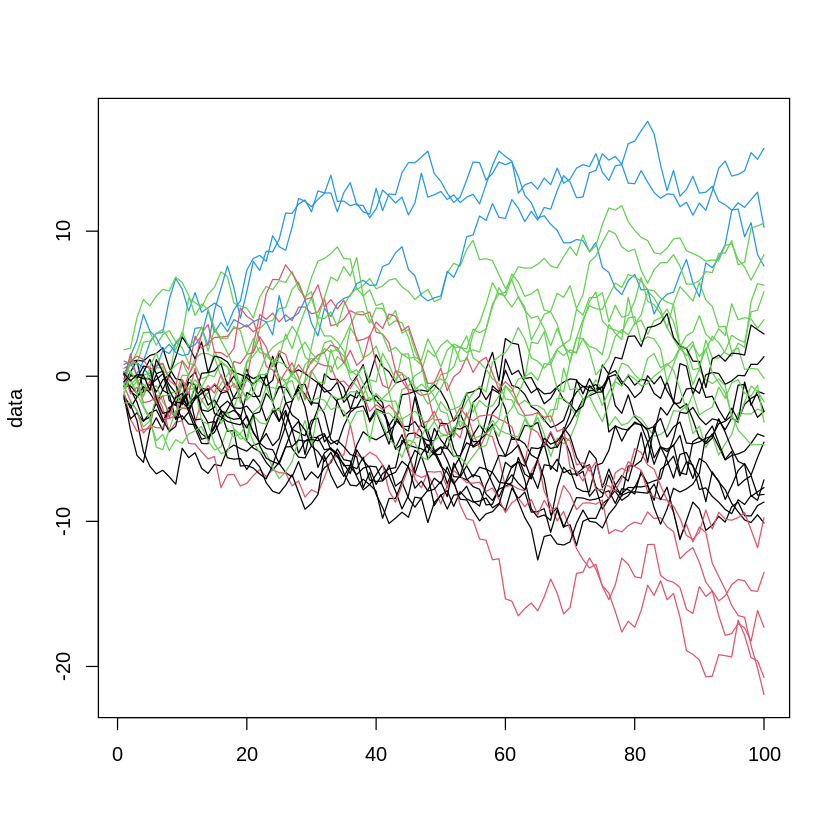

In [18]:
# 5.7 時系列クラスタリング

# 1次元データのDTWと時系列クラスタリング
library(TSclust)

# データの作成
# ランダムウォークを返す関数
RndWalk1D <- function(n){
  rndwalk <- cumsum(rnorm(n))
  return(rndwalk)
}

N <- 30 # 時系列サンプルのサイズ
LEN <- 100 # 時系列サンプルの長さ
data <- apply(matrix(NA, nrow=LEN, ncol=N), 2, RndWalk1D)
data <- as.data.frame(data)

# 時系列クラスタリング
d <- diss(data, "DTWARP") # 距離の指標としてDTW距離を指定する
h <- hclust(d, method = "ward.D") # Ward法による階層クラスタリング
plot(h, hang = -1) # デンドログラムを描画する
NUMCLASS <-4 # 何クラスに分類して結果を表示するか
h.cluster <- cutree(h, NUMCLASS) # 属するクラスタの情報を返す
matplot(data, type = 'l', lty = 1, col = h.cluster) # 描画

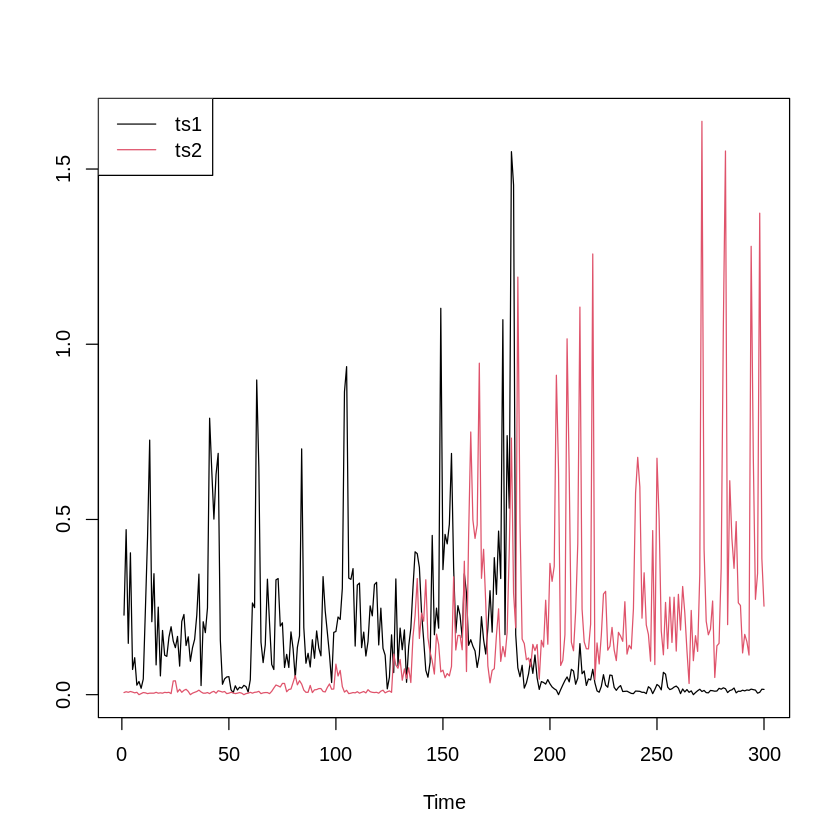

[1] "再帰率：0.127064"

[1] "最大線長：108"

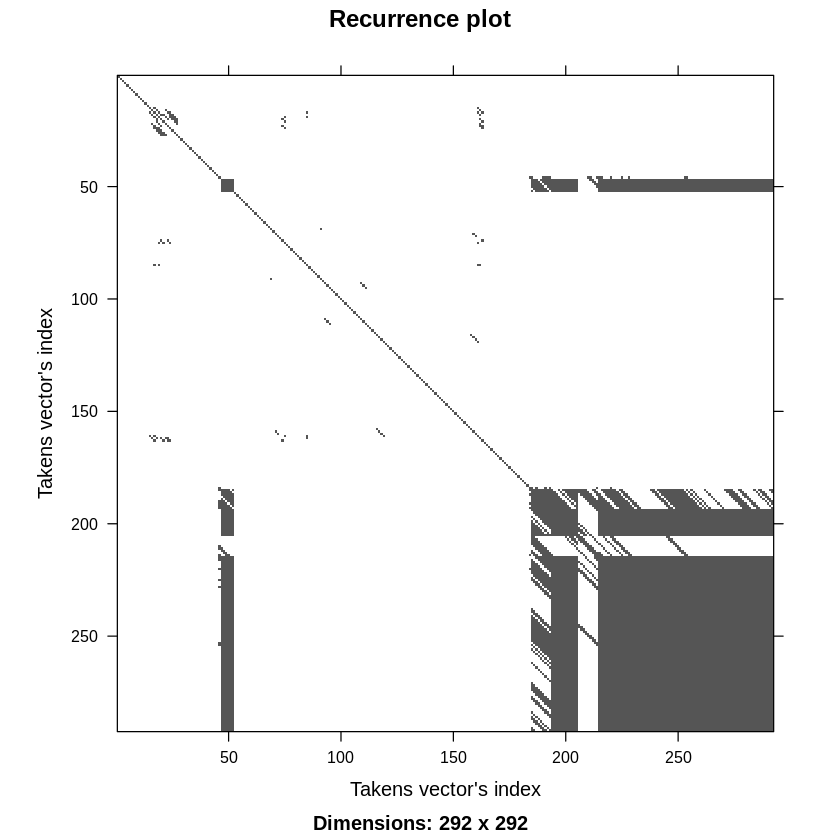

[1] "再帰率：0.427611"

[1] "最大線長：86"

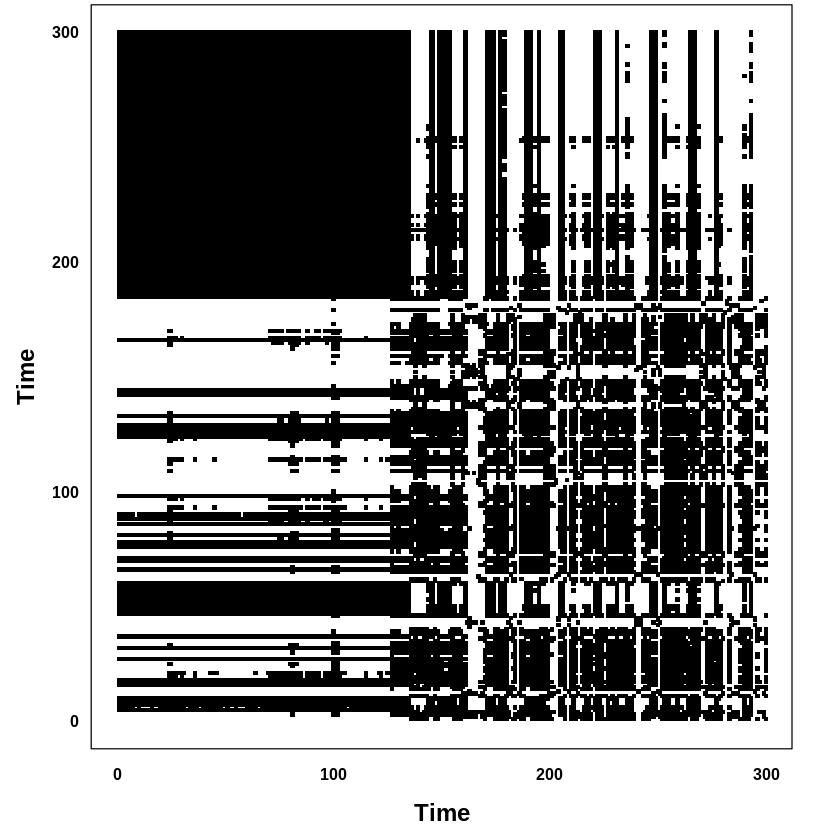

In [19]:
# 5.8 再帰定量化分析

library(crqa) # 相互再帰定量化分析のためのパッケージ
library(nonlinearTseries) # 非線形時系列データ分析パッケージ

# 再帰定量化分析（RQA）
# データの準備
data(crqa) # 対話中の２者の手や視線の動きのデータが含まれている
ts1 <- handmovement$P1_TT_d[1:300]
ts2 <- handmovement$P2_TT_d[1:300]
ts.plot(cbind(ts1,ts2), col=c(1,2))
legend("topleft", legend = c("ts1","ts2"), col = 1:2, lty = 1)
# 相互情報量から埋め込み遅延時間（ τ ）を決定する
tau.ami = timeLag(ts1, technique = "ami",do.plot = FALSE)
# 埋め込み次元の決定
emb.dim = estimateEmbeddingDim(ts1, time.lag = tau.ami, do.plot = FALSE)
# リカレンスプロットの描画と指標の算出
ts1.rqa <- rqa(time.series = ts1, embedding.dim=emb.dim, time.lag= tau.ami,
               radius=0.1, lmin=2,do.plot=TRUE)
sprintf("再帰率：%f",ts1.rqa$REC)
sprintf("最大線長：%d",ts1.rqa$Lmax)


# 相互再帰定量化分析（CRQA)
library(crqa) # 相互再帰定量化分析のためのパッケージ
par = list(method = "crqa", metric = "euclidean", maxlag = 10,
           radiusspan = 1000, normalize = 0,rescale = 4,
           mindiagline = 10,minvertline = 10, tw = 0,
           whiteline = FALSE, recpt = FALSE, side = "both",
           datatype = "continuous",typeami = "mindip", nbins = 50)

# 遅れ時間と埋め込み次元を決定する
param <- optimizeParam(ts1, ts2, par=par)
res <- crqa(ts1, ts2, delay = param$delay, embed = param$emddim,
            radius = 0.1, normalize = 0, mindiagline = 2,
            minvertline = 2, tw = 0, method = "crqa", side = "both",
            datatype = "continuous")
plotRP(res$RP,par=list(unit = 100, labelx = "Time",
                       labely = "Time", cols = "black",
                       pcex = .5, pch = 15,
                       labax = seq(0, nrow(res$RP), 100),
                       labay = seq(0, nrow(res$RP), 100),
                       las = 1))
sprintf("再帰率：%f",res$RR/100) # パーセンテージを率に変換している
sprintf("最大線長：%d",res$maxL)


,1,2,3,4,5
AIC(n),-1.0800918,-1.0148858,-0.9703941,-0.9124924,-0.8461046
HQ(n),-1.0149156,-0.9062587,-0.8183160,-0.7169635,-0.6071249
SC(n),-0.9187944,-0.7460567,-0.5940332,-0.4285999,-0.2546805
FPE(n),0.3395786,0.3625144,0.3791365,0.4019802,0.4299794



VAR Estimation Results:
Endogenous variables: y1, y2 
Deterministic variables: const 
Sample size: 99 
Log Likelihood: -225.253 
Roots of the characteristic polynomial:
0.6632 0.6632
Call:
VAR(y = df, p = 1, type = "const")


Estimation results for equation y1: 
y1 = y1.l1 + y2.l1 + const 

      Estimate Std. Error t value Pr(>|t|)    
y1.l1  0.31900    0.08185   3.897  0.00018 ***
y2.l1  0.59075    0.09846   6.000 3.49e-08 ***
const  9.55371    1.93630   4.934 3.38e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.9997 on 96 degrees of freedom
Multiple R-Squared: 0.4898,	Adjusted R-squared: 0.4791 
F-statistic: 46.08 on 2 and 96 DF,  p-value: 9.387e-15 


Estimation results for equation y2: 
y2 = y1.l1 + y2.l1 + const 

      Estimate Std. Error t value Pr(>|t|)    
y1.l1 -0.49026    0.08238  -5.951 4.34e-08 ***
y2.l1  0.47095    0.09910   4.752 7.06e-06 ***
const 20.16133    1.94894  10.345  < 2e-16 ***
---
Signif. codes:  0 ‘**

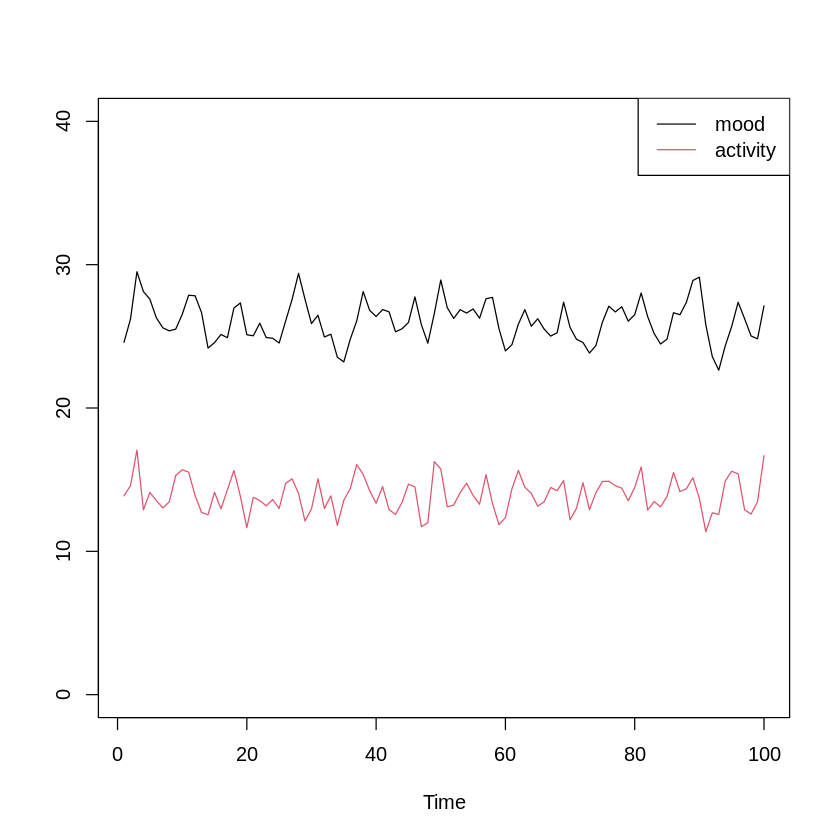

$Granger

	Granger causality H0: y2 do not Granger-cause y1

data:  VAR object var_model
F-Test = 35.999, df1 = 1, df2 = 192, p-value = 9.651e-09


$Instant

	H0: No instantaneous causality between: y2 and y1

data:  VAR object var_model
Chi-squared = 39.321, df = 1, p-value = 3.596e-10



$Granger

	Granger causality H0: y1 do not Granger-cause y2

data:  VAR object var_model
F-Test = 35.413, df1 = 1, df2 = 192, p-value = 1.244e-08


$Instant

	H0: No instantaneous causality between: y1 and y2

data:  VAR object var_model
Chi-squared = 39.321, df = 1, p-value = 3.596e-10



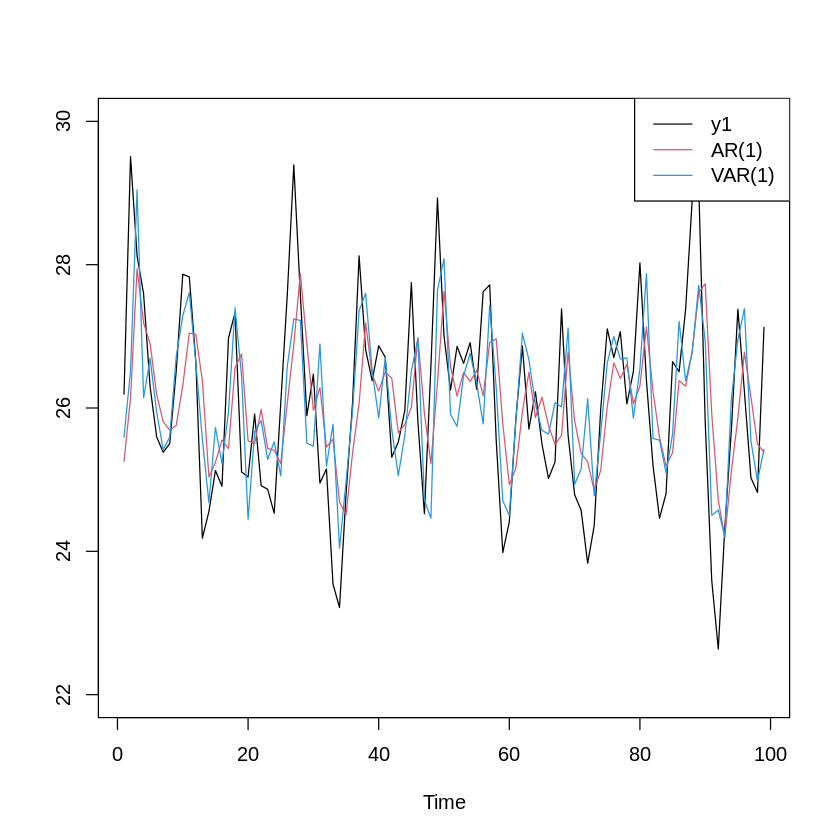

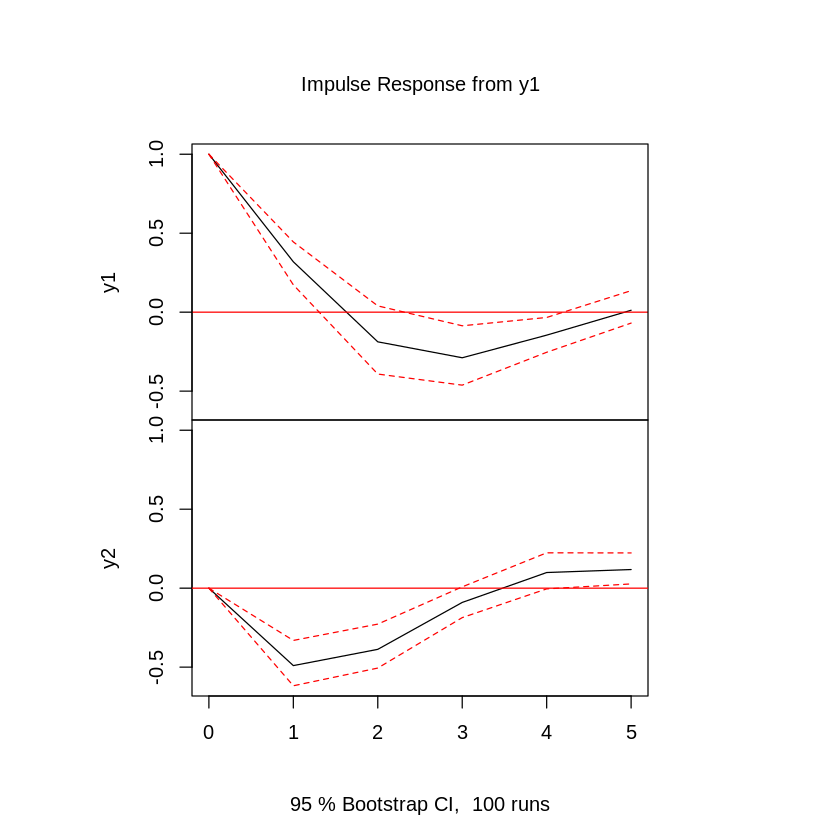

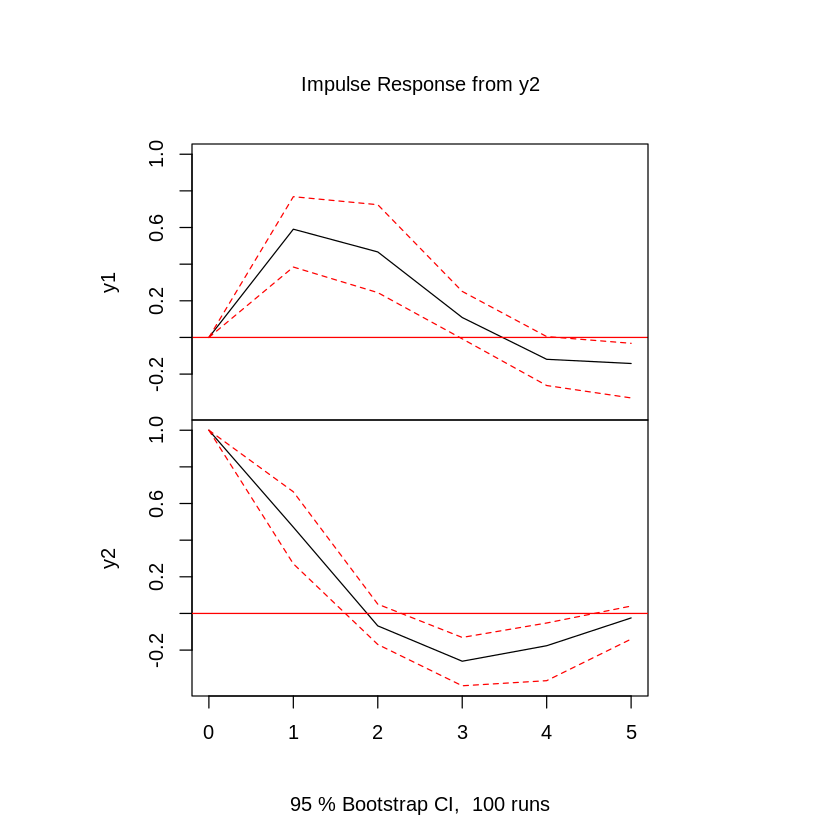

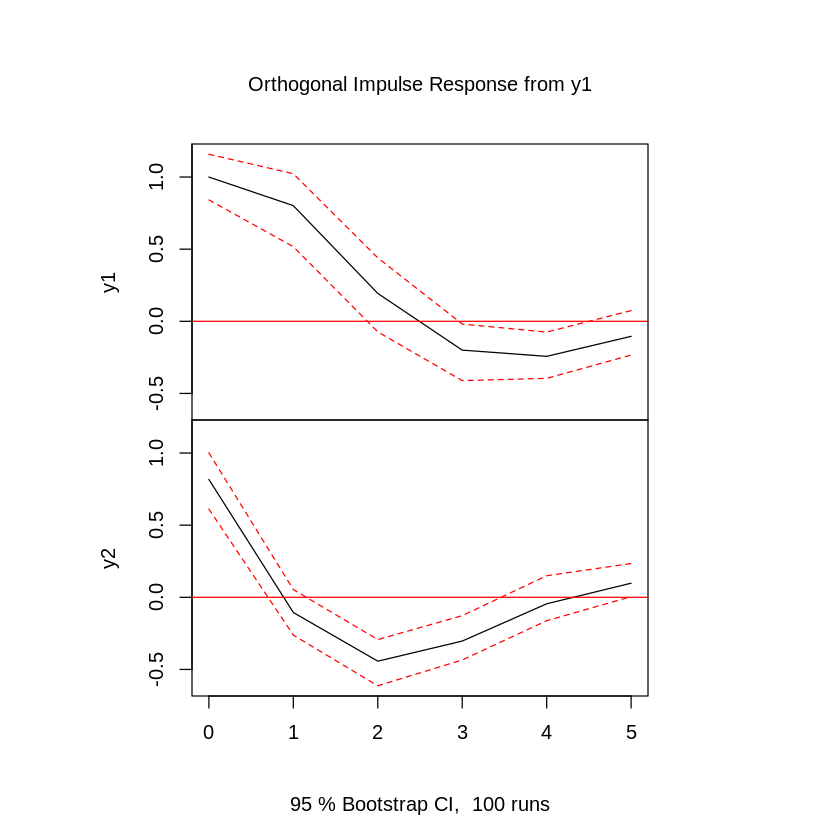

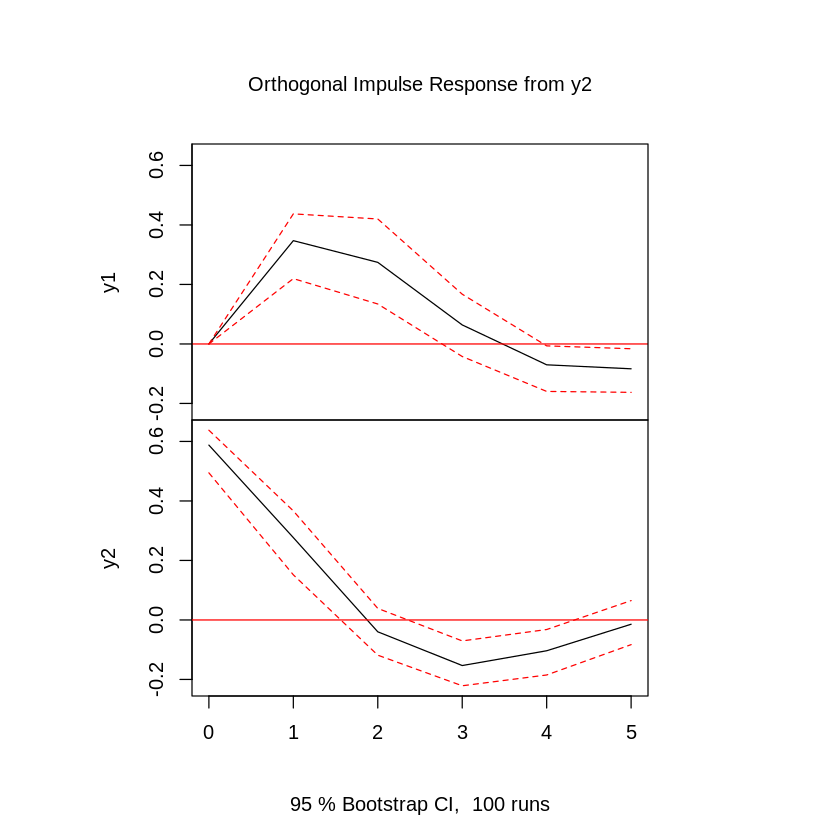

In [20]:
# 5.9 グレンジャー因果性検定と VAR モデル

library(tsDyn)
library(vars)

# 5.9.1 VAR モデル
# 仮想時系列データの作成
# 係数行列
B<-matrix(c(10,20,0.3,-0.5,0.6,0.5), 2)
# 初期値
S <- matrix(c(25,10),1)
# 撹乱項の分散共分散行列
V <- matrix(c(1,0.8,0.8,1), nrow=2, ncol=2)
# include="const"で切片(定数項)ありのモデルでデータを作成
set.seed(9999)
dat <- VAR.sim(B=B, n=100, lag=1, include="const", starting = S, varcov = V)
df <- data.frame(y1 = dat[,1], y2=dat[,2])
# 作図
ts.plot(df, gpars=list(ylim=c(0,40), col=c(1:2)))
legend("topright", legend = c("mood","activity"), lty=1, col=c(1:2))


# 5.9.2 VAR モデルの選択
VARselect(df, lag.max=5, type = "const")

var_model <- VAR(df, p=1, type = "const")
summary(var_model)

# ARモデルとVARモデルによる予測
library(forecast)
ar_model <-Arima(df$y1,order=c(1,0,0), include.constant = T)
df2 <- data.frame(y1 = dat[-1,1],
                  AR=ar_model$fitted[-1],
                  var_model$varresult$y1$fitted.values)
ts.plot(df2, gpars=list(ylim=c(22,30), col=c(1,2,4)))
legend("topright", legend = c("y1","AR(1)", "VAR(1)"), lty=1, col=c(1,2,4))


# 5.9.3 グレンジャー因果性検定
causality(var_model, cause = "y2") # y_2からy_1への因果性検定
causality(var_model, cause = "y1") # y_1からy_2への因果性検定


# 5.9.4 直交化インパルス応答関数
#（非直交化）インパルス応答関数
impulse_func <- irf(var_model, n.ahead=5, orth=FALSE)
plot(impulse_func)

# 直交化インパルス応答関数
ortho_impulse_func <- irf(var_model, n.ahead=5, orth=TRUE)
plot(ortho_impulse_func)
